# fig_grpBeh

### This notebook generates figures related to generating group behavioral results
    
 
    
    

In [1]:
%%capture
#import packages
import numpy as np # numpy
import pandas as pd # pandas
import mne
import pickle
import os
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,spatial
import numpy.random as rand
import pycircstat as circ
import fooof as ff
import tensorpac as tp
import ccdt_func as cc
from sklearn.metrics import r2_score,pairwise_distances
# plotting
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.size'] = 20
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 

# create fig dir
fig_dir = os.getcwd()+'/figs/fig_grpBeh/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')
def clean_fig(apply_int=True):
    plt.gca().set_yticks(np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],3))
    plt.gca().set_xticks(np.linspace(plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],3))
    if apply_int==True:
        plt.gca().set_yticklabels(plt.gca().get_yticks().astype('int'),fontsize=20)
        plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
    else:
        plt.gca().set_yticklabels(np.round(plt.gca().get_yticks(),2),fontsize=20)
        plt.gca().set_xticklabels(np.round(plt.gca().get_xticks(),2),fontsize=20)


GB = cc.GroupBehavior()


In [2]:
%%capture
# collect param_df
fp_dict_list = []
evQuery_correct = 'error==0&fastResponse==0'
for s in np.arange(0,len(GB.subj_list)):
    
    # initialize Subject
    S = cc.Subject(subj = GB.subj_list[s]) 
    
    # collect error and fast response rate
    choiceEv = S.ev_df.query('type=="RESPONSE"')
    
    fp_dict={}
    fp_dict['subj'] = S.subj
    fp_dict['n_trials'] = len(choiceEv)
    fp_dict['n_sess'] = len(np.unique(choiceEv['session']))
    fp_dict['mean_rt'] = np.mean(choiceEv.query(evQuery_correct)['RT'].to_numpy())
    fp_dict['std_rt'] = np.std(choiceEv.query(evQuery_correct)['RT'].to_numpy())
    
    fp_dict['mean_rtL'] = np.mean(choiceEv.query(evQuery_correct+'&delay==1500')['RT'].to_numpy())
    fp_dict['std_rtL'] = np.std(choiceEv.query(evQuery_correct+'&delay==1500')['RT'].to_numpy())
    fp_dict['iqr_rtL'] = stats.iqr(choiceEv.query(evQuery_correct+'&delay==1500')['RT'].to_numpy())

    fp_dict['mean_rtS'] = np.mean(choiceEv.query(evQuery_correct+'&delay==500')['RT'].to_numpy())
    fp_dict['std_rtS'] = np.std(choiceEv.query(evQuery_correct+'&delay==500')['RT'].to_numpy())
    fp_dict['iqr_rtS'] = stats.iqr(choiceEv.query(evQuery_correct+'&delay==500')['RT'].to_numpy())

    
    # rt diff
    fp_dict['rtDiff_mean'] = fp_dict['mean_rtL'] - fp_dict['mean_rtS']
    fp_dict['rtDiff_std'] = fp_dict['std_rtL'] - fp_dict['std_rtS']
    
    
    fp_dict['error_rate'] = (np.sum(choiceEv.eval('RT<0'))/len(choiceEv))
    fp_dict['error_rateS'] = (np.sum(choiceEv.eval('RT<0&delay==500'))/np.sum(choiceEv.eval('delay==500')))
    fp_dict['error_rateL'] = (np.sum(choiceEv.eval('RT<0&delay==1500'))/np.sum(choiceEv.eval('delay==1500')))
    fp_dict['error_diff'] = fp_dict['error_rateL'] - fp_dict['error_rateS']
    
    fp_dict['lapse_rate'] = (np.sum(choiceEv.eval('RT>=1000'))/len(choiceEv))
    fp_dict['lapse_rateS'] = (np.sum(choiceEv.eval('RT>=1000&delay==500'))/np.sum(choiceEv.eval('delay==500')))
    fp_dict['lapse_rateL'] = (np.sum(choiceEv.eval('RT>=1000&delay==1500'))/np.sum(choiceEv.eval('delay==1500')))
    fp_dict['lapse_diff'] = fp_dict['lapse_rateL'] - fp_dict['lapse_rateS']
    
    # fit LATER2
    rts_A,rts_B,pred_idx_A,pred_idx_B = S.getRTs_for_LATER2()

    # FIT LATER 2
    fp_dict.update(S.fitLATER2_byCondition(rts_A,rts_B,pred_idx_A, pred_idx_B,model_type = 'std_bias'))#model_type = 'mean_bias'
    
    
    # update list
    fp_dict_list.append(fp_dict)

    # PLOT
    S.plotLATER2_fits()
    
    save_fig('LATER2_fits-'+str(S.subj))
    
    
# get data frame
fp_df = pd.DataFrame(fp_dict_list) 

In [3]:
print(np.median(fp_df['iqr_rtS']))

print(np.median(fp_df['iqr_rtL']))

66.667412000068
66.75452780723572


In [4]:
#print subject table
fp_df.to_csv(path_or_buf=fig_dir+'subj_table.csv',float_format=None)

long delay stats r = 0.69 p =0.0


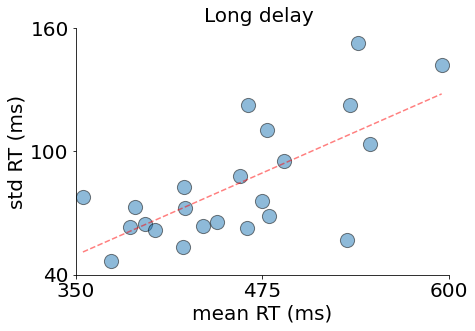

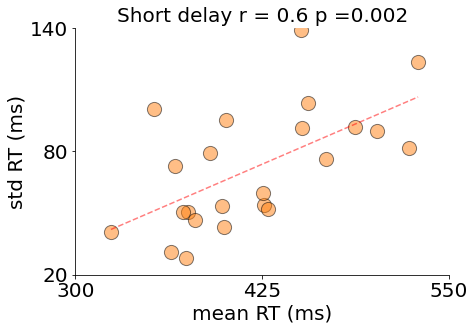

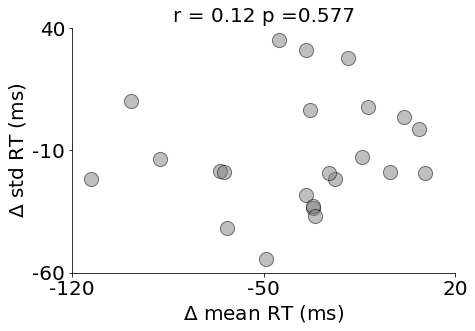

In [5]:
# Mean vs. STD RT on short delay (color indicates error rate )
x,y=S.plot_scatter(fp_df['mean_rtS'],fp_df['std_rtS'],s=200,plotLine=True,color='C0');
ax = plt.gca()
ax.set_xlabel('mean RT (ms)',fontsize=20)
ax.set_ylabel('std RT (ms)',fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print('long delay stats',ax.get_title())
ax.set_title('Long delay ',fontsize=20)
clean_fig()
save_fig('rtdistL_mean_std')

# Mean vs. STD RT on Long delay (color indicates error rate )
x,y=S.plot_scatter(fp_df['mean_rtL'],fp_df['std_rtL'],s=200,plotLine=True,color='C1');
ax = plt.gca()
ax.set_xlabel('mean RT (ms)',fontsize=20)
ax.set_ylabel('std RT (ms)',fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.set_title('Short delay '+ax.get_title(),fontsize=20)
clean_fig()
save_fig('rtdistS_mean_std')

# Mean vs. STD RT on Long delay (color indicates error rate )
x,y=S.plot_scatter(fp_df['rtDiff_mean'],fp_df['rtDiff_std'],s=200,plotLine=True,color='0.5');
ax = plt.gca()
ax.set_xlabel('$\Delta$ mean RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ std RT (ms)',fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.set_title(ax.get_title(),fontsize=20)
clean_fig()
save_fig('rtdiff_mean_std')

Short delay stats r = -0.13 p =0.548
long delay stats r = -0.47 p =0.023


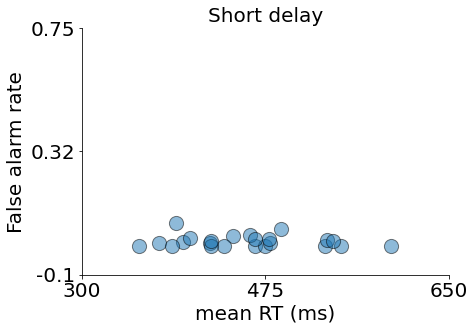

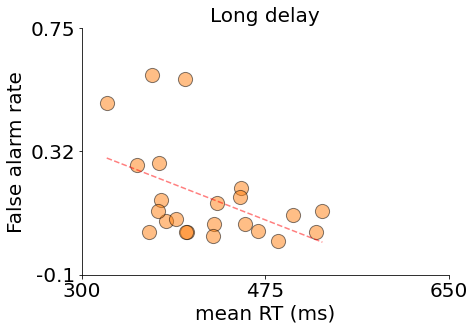

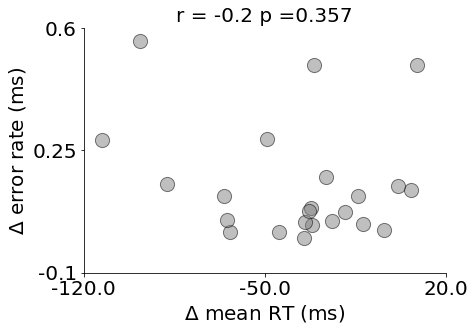

In [6]:
# mean vs. error rate

x,y=S.plot_scatter(fp_df['mean_rtS'],fp_df['error_rateS'],s=200,plotLine=True,color='C0',cmap='Reds',use_spearman=False);
ax = plt.gca()
ax.set_xlabel('mean RT (ms)',fontsize=20)
ax.set_ylabel('False alarm rate',fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print('Short delay stats',ax.get_title())
ax.set_title('Short delay',fontsize=20)
ax.set_ylim((-.1,0.75))
ax.set_xlim((300,650))
clean_fig(apply_int=False)
ax.set_xticklabels(np.array(ax.get_xticks()).astype('int'))
save_fig('rtdistS_mean_error')


x,y=S.plot_scatter(fp_df['mean_rtL'],fp_df['error_rateL'],s=200,plotLine=True,color='C1',cmap='Reds',use_spearman=False);
ax = plt.gca()
ax.set_xlabel('mean RT (ms)',fontsize=20)
ax.set_ylabel('False alarm rate',fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print('long delay stats',ax.get_title())
ax.set_title('Long delay',fontsize=20)
ax.set_ylim((-.1,0.75))
ax.set_xlim((300,650))
clean_fig(apply_int=False)
ax.set_xticklabels(np.array(ax.get_xticks()).astype('int'))
save_fig('rtdistL_mean_error')


# Mean vs. STD RT on Long delay (color indicates error rate )
x,y=S.plot_scatter(fp_df['rtDiff_mean'],fp_df['error_diff'],s=200,plotLine=True,color='0.5',use_spearman=False);
ax = plt.gca()
ax.set_xlabel('$\Delta$ mean RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ error rate (ms)',fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.set_title(ax.get_title(),fontsize=20)
clean_fig(apply_int=False)
save_fig('rtdiff_mean_error')

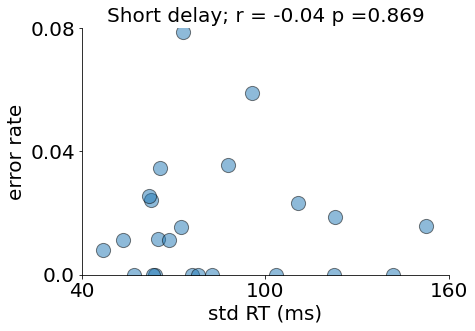

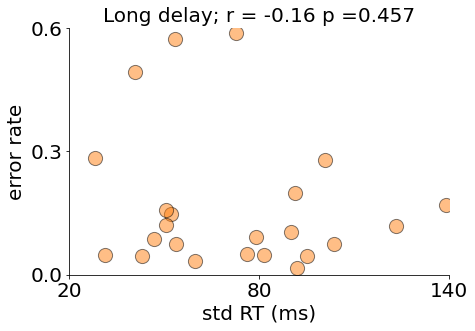

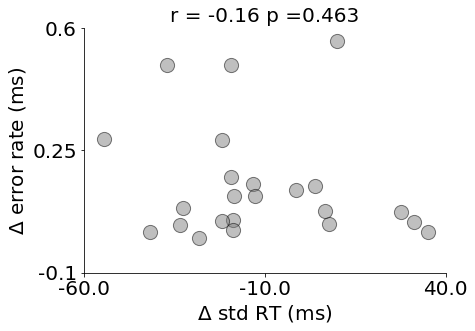

In [7]:
# std vs. error rate

x,y=S.plot_scatter(fp_df['std_rtS'],fp_df['error_rateS'],s=200,plotLine=True,color='C0',cmap='Reds');
ax = plt.gca()
ax.set_xlabel('std RT (ms)',fontsize=20)
ax.set_ylabel('error rate',fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.set_title('Short delay; '+ax.get_title(),fontsize=20)
clean_fig(apply_int=False)
ax.set_xticklabels(np.array(ax.get_xticks()).astype('int'))
save_fig('rtdistS_std_error')


x,y=S.plot_scatter(fp_df['std_rtL'],fp_df['error_rateL'],s=200,plotLine=True,color='C1',cmap='Reds');
ax = plt.gca()
ax.set_xlabel('std RT (ms)',fontsize=20)
ax.set_ylabel('error rate',fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.set_title('Long delay; '+ax.get_title(),fontsize=20)
clean_fig(apply_int=False)
ax.set_xticklabels(np.array(ax.get_xticks()).astype('int'))
save_fig('rtdistL_std_error')


# Mean vs. STD RT on Long delay (color indicates error rate )
x,y=S.plot_scatter(fp_df['rtDiff_std'],fp_df['error_diff'],s=200,plotLine=True,color='0.5');
ax = plt.gca()
ax.set_xlabel('$\Delta$ std RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ error rate (ms)',fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.set_title(ax.get_title(),fontsize=20)
clean_fig(apply_int=False)
save_fig('rtdiff_std_error')

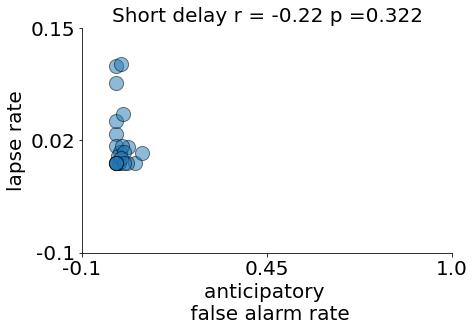

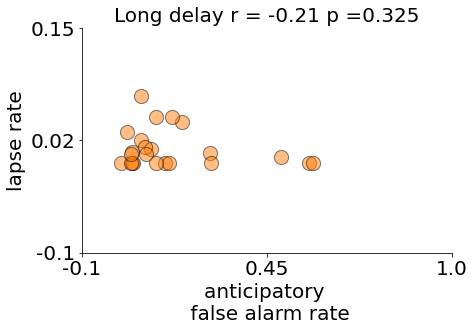

In [8]:
# contrast error rate and lapse rate
x,y=S.plot_scatter(fp_df['error_rateS'],fp_df['lapse_rateS'],s=200,plotLine=True,color='C0',cmap='Reds');
ax = plt.gca()
ax.set_xlabel('anticipatory \n false alarm rate',fontsize=20)
ax.set_ylabel('lapse rate',fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.set_title('Short delay '+ax.get_title(),fontsize=20)
ax.set_xlim((-.1,1))
ax.set_ylim((-.1,0.15))
clean_fig(apply_int=False)
save_fig('error_lapseS')


x,y=S.plot_scatter(fp_df['error_rateL'],fp_df['lapse_rateL'],s=200,plotLine=True,color='C1',cmap='Reds');
ax = plt.gca()
ax.set_xlabel('anticipatory \n false alarm rate',fontsize=20)
ax.set_ylabel('lapse rate',fontsize=20)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax.set_title('Long delay '+ax.get_title(),fontsize=20)
ax.set_xlim((-.1,1))
ax.set_ylim((-.1,0.15))
clean_fig(apply_int=False)
save_fig('error_lapseL')

/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2524: RuntimeWarning: divide by zero encountered in true_divide
  ax.set_xticklabels(labels = -1*np.round(1/ax.get_xticks(),1),fontsize=fig_params['fsize_tick'])
/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2524: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = -1*np.round(1/ax.get_xticks(),1),fontsize=fig_params['fsize_tick'])
/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2524: RuntimeWarning: divide by zero encountered in true_divide
  ax.set_xticklabels(labels = -1*np.round(1/ax.get_xticks(),1),fontsize=fig_params['fsize_tick'])
/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2524: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = -1*np.round(1/ax.get_xticks(),1),fontsize=fig_params['fsize_tick'])
/home/ashwinra

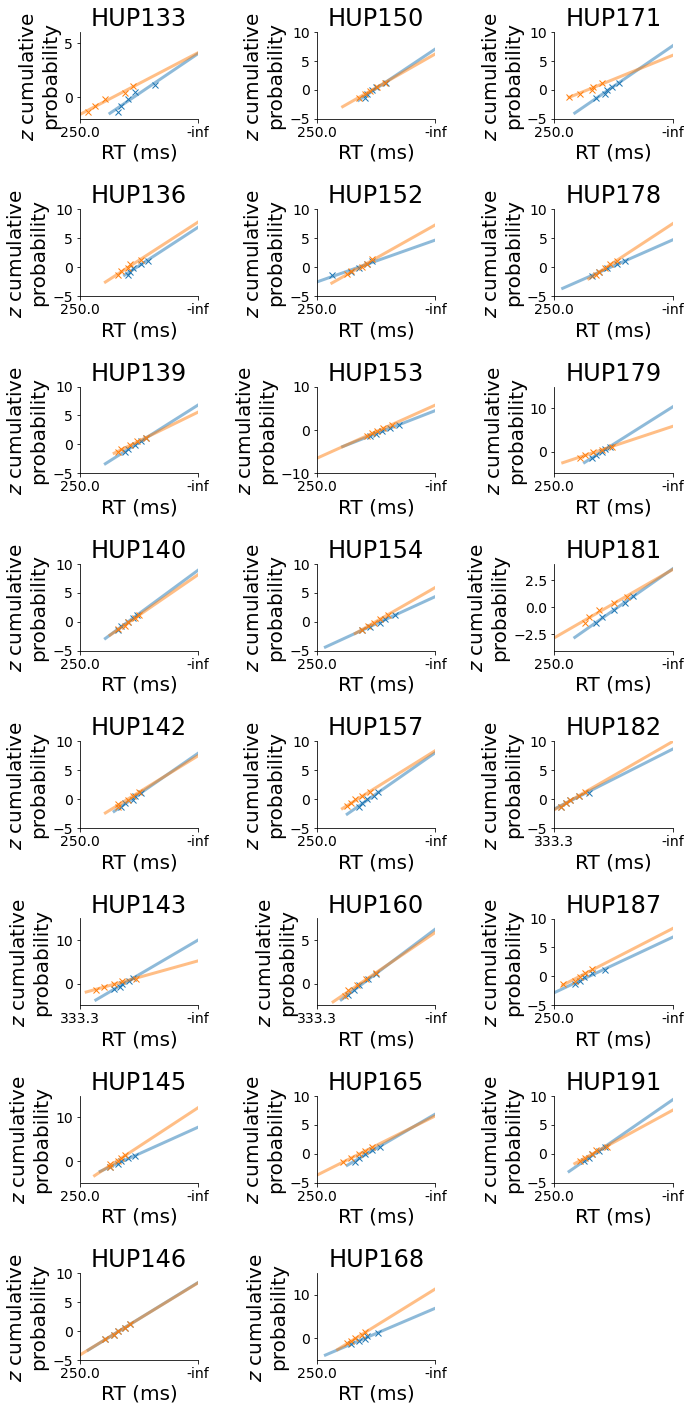

In [9]:
# plot RECIPROBIT
f = plt.figure(figsize=(10,20))
gs = plt.GridSpec(int(len(GB.subj_list)/3)+1, 3, figure=f)
count=-1
col = 0

fp_dict_list = []

for s in np.arange(0,len(GB.subj_list)):
    
    subj = GB.subj_list[s]
    
    count+=1
    
    if (col==0)&(count==int(len(GB.subj_list)/3)+1):
        count = 0
        col = 1
    elif (col==1)&(count==int(len(GB.subj_list)/3)+1):
        count = 0
        col = 2        
        

    # initialize Subject
    S = cc.Subject(subj = subj) 

    ax=f.add_subplot(gs[count,col])
    
    S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==500',\
         plot_type='reciprobit',
         plot_median=False,
         yL=None,
         model_type='mean_std',color ='C0',
         alpha = 0.5,
         bins = None,apply_reciprobit_smooth=False, reciprobit_sd = 5)
    
#     S.plotRT(ax = ax,evQuery='error==1|fastResponse==1',\
#          plot_type='reciprobit',
#          plot_median=False,
#          yL=None,
#          model_type='mean_std',color ='r',
#          alpha = 0.5,
#          bins = None,apply_reciprobit_smooth=False, reciprobit_sd = 5)
        
    S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==1500',\
         plot_type='reciprobit',
         plot_median=False,
         yL=None,
         model_type='mean_std',color ='C1',
         alpha = 0.5,
         bins = None,apply_reciprobit_smooth=False, reciprobit_sd = 5)
    S.set_axes_rt(ax=plt.gca(),plot_type = 'reciprobit',add_legend=False)

    # Populate model title with later 2 parameters
    pd_M  = fp_df.query('subj==@subj')['paramsDiff_M'].to_numpy()[0]
    pd_D  = fp_df.query('subj==@subj')['paramsDiff_D'].to_numpy()[0]
    pd_B  = fp_df.query('subj==@subj')['paramsDiff_B'].to_numpy()[0]
    mod_tit = '$\Delta$M {M:.2f} $\Delta$D {D:.2f} $\Delta$B {B:.2f}'.format(M=pd_M,D=pd_D,B=pd_B) 
    
    #ax.set_title(S.subj+'-'+mod_tit)
    ax.set_title(S.subj)
    #if (count>0)|(col>0):
    #    #ax.set_xlabel('')
        
    
    #if s<len(GB.subj_list)-1:
    #    ax.set_xticks([])
    xtl = ax.get_xticklabels()
    ax.set_xticks((ax.get_xticks()[0],ax.get_xticks()[-1]))
    ax.set_xticklabels([xtl[0],xtl[-1]])
    ax.set_ylabel('$z$ cumulative \nprobability')
    #ax.get_legend().remove()
    
    
# save fig    
save_fig('GroupRT_foreperiod_reciprobit')

0.8364131924997721
18
0


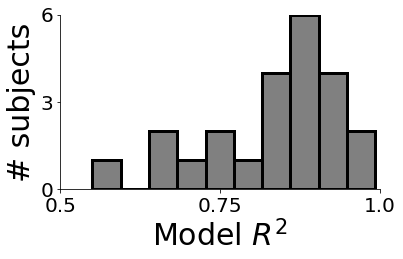

In [10]:
f = plt.figure()
plt.hist(fp_df['rsquared'].to_numpy(),color = '0.5',linewidth=3,edgecolor = 'k');
plt.gca().set_xlabel('Model $R^{2}$',fontsize=30)
plt.gca().set_ylabel('# subjects',fontsize=30)
clean_fig(apply_int=False)
plt.gca().set_yticklabels(plt.gca().get_yticks().astype('int'))

save_fig('r2_dist_fullModel')

print(np.mean(fp_df['rsquared'].to_numpy()))

print(np.sum(fp_df['rsquared'].to_numpy()>0.75))
print(np.sum(fp_df['rsquared'].to_numpy()<=0.5))

mean short 457.0177127368887
mean long 419.36989911774316
paired t stat:5.57; pval:0.0
 f stat:4.62; pval:0.04
paired t stat:2.4; pval:0.03
 f stat:1.87; pval:0.18
paired t stat:-4.43; pval:0.0
 f stat:18.29; pval:0.0


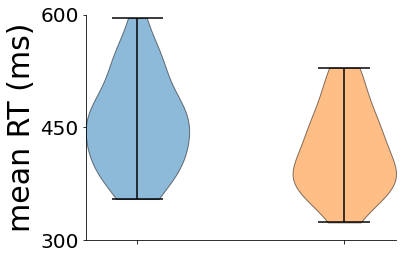

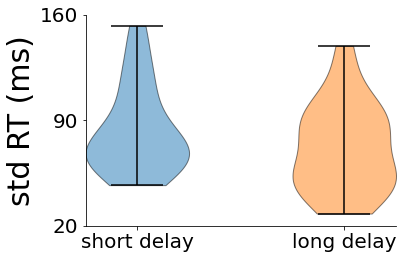

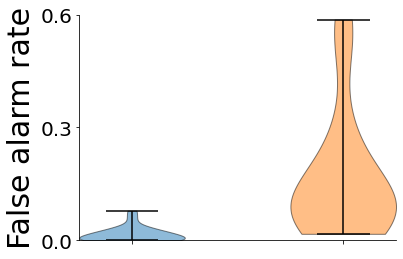

In [11]:
def vplot(x,y,ylabel,cond_lbl,apply_int=True,col_list=['C0','C1']):
    f = plt.figure()
    ax = plt.subplot(111)
    vp = ax.violinplot((x,y))
    for i in np.arange(0,len(vp['bodies'])):
        vp['bodies'][i].set_facecolor(col_list[i])
        vp['bodies'][i].set_edgecolor('k')
        vp['bodies'][i].set_alpha(0.5)
    vp['cmins'].set_color('k')
    vp['cbars'].set_color('k')
    vp['cmaxes'].set_color('k')
    
    #paired ttest
    tstat,pval = stats.ttest_1samp(x-y,popmean=0)
    #tstat,pval = stats.ttest_ind(x,y,equal_var=False)
    fstat,pval_anov = stats.f_oneway(x,y)
    ax.set_ylabel(ylabel,fontsize=30)
    clean_fig(apply_int)
    ax.set_xticks([1,2])
    ax.set_xticklabels(cond_lbl)
    print('paired t stat:'+str(np.round(tstat,2))+\
                 '; pval:'+str(np.round(pval,2))+\
                 '\n f stat:'+str(np.round(fstat,2))+\
                 '; pval:'+str(np.round(pval_anov,2)))
    

print('mean short',fp_df['mean_rtS'].mean())
print('mean long',fp_df['mean_rtL'].mean())
vplot(fp_df['mean_rtS'],fp_df['mean_rtL'],'mean RT (ms)',\
      ('',''))
save_fig('fp_meanRt_violin')

vplot(fp_df['std_rtS'],fp_df['std_rtL'],'std RT (ms)',\
      ('short delay','long delay'))
save_fig('fp_stdRt_violin')

vplot(fp_df['error_rateS'],fp_df['error_rateL'],'False alarm rate',\
      ('',''),apply_int=False)
save_fig('fp_errorRate_violin')



r = -0.63 p =0.001


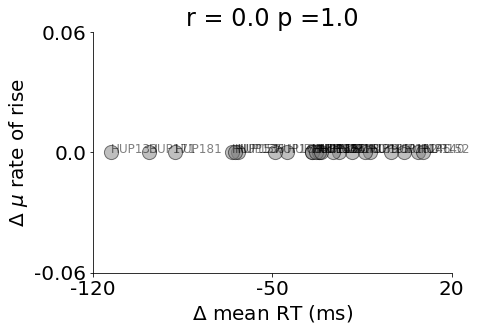

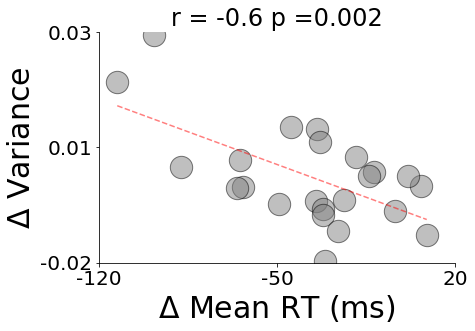

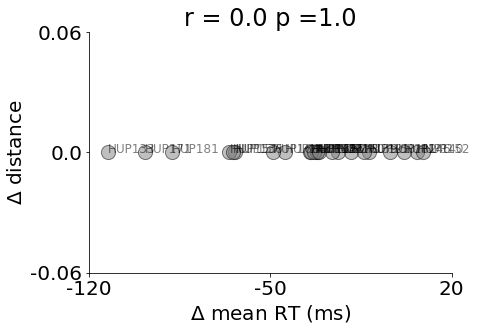

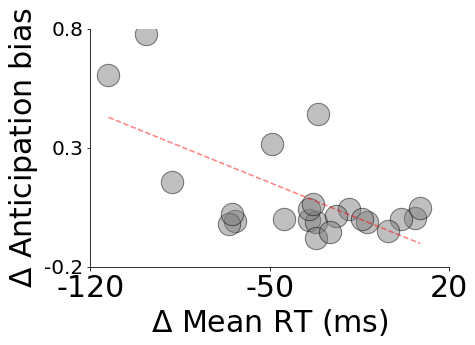

In [12]:
#LATER model parameters vs. RT changes
remove_zeros=False

###  RT mean 

# vs M (mean rate of rise)
S.plot_scatter(fp_df['rtDiff_mean'].to_numpy(),fp_df['paramsDiff_M'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ mean RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ $\mu$ rate of rise',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_M_rtMean)')

# # vs S (std of rate of rise)
S.plot_scatter(fp_df['rtDiff_mean'].to_numpy(),fp_df['paramsDiff_S'].to_numpy(),\
               remove_zeros=remove_zeros,s=500);#,text_lbls=fp_df['subj'].to_numpy()
ax = plt.gca()
ax.set_xlabel('$\Delta$ Mean RT (ms)',fontsize=30)
#ax.set_ylabel('$\Delta$ $\sigma$ rate of rise',fontsize=30)
ax.set_ylabel('$\Delta$ Variance',fontsize=30)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_S_rtMean)')



# vs D (distance)
S.plot_scatter(fp_df['rtDiff_mean'].to_numpy(),fp_df['paramsDiff_D'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ mean RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ distance',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_D_rtMean)')


# vs B (prediction bias)
S.plot_scatter(fp_df['rtDiff_mean'].to_numpy(),fp_df['paramsDiff_B'].to_numpy(),\
               remove_zeros=remove_zeros,s=500, use_spearman = False);#,text_lbls=fp_df['subj'].to_numpy()
ax = plt.gca()
ax.set_xlabel('$\Delta$ Mean RT (ms)',fontsize=30)
ax.set_ylabel('$\Delta$ Anticipation bias',fontsize=30)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=30)
print(plt.gca().get_title())
plt.gca().set_title('')
save_fig('fp_later_B_rtMean)')

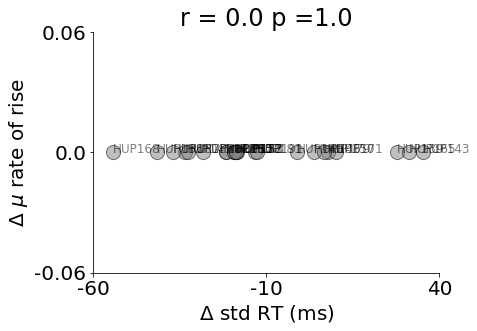

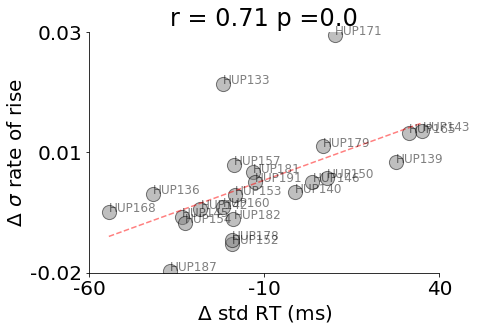

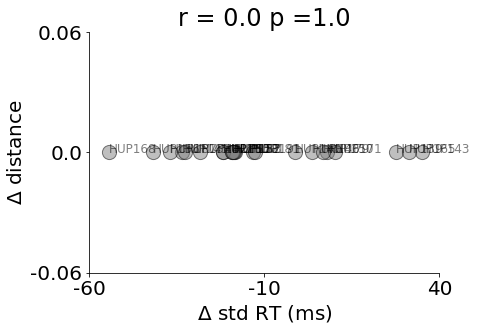

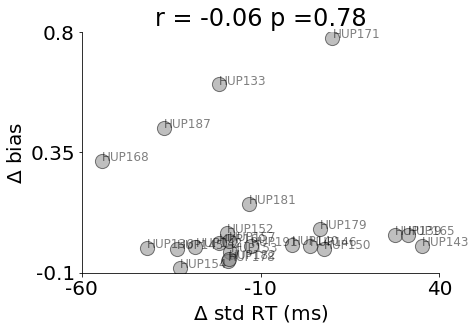

In [13]:
###  RT std 

# vs M (mean rate of rise)
S.plot_scatter(fp_df['rtDiff_std'].to_numpy(),fp_df['paramsDiff_M'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ std RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ $\mu$ rate of rise',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_M_rtStd)')


# # vs S (std rate of rise)
S.plot_scatter(fp_df['rtDiff_std'].to_numpy(),fp_df['paramsDiff_S'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df['subj'].to_numpy(), use_spearman = True);
ax = plt.gca()
ax.set_xlabel('$\Delta$ std RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ $\sigma$ rate of rise',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_D_rtStd)')

# vs Distance
S.plot_scatter(fp_df['rtDiff_std'].to_numpy(),fp_df['paramsDiff_D'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ std RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ distance',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_D_rtStd)')


# vs prediction bias
S.plot_scatter(fp_df['rtDiff_std'].to_numpy(),fp_df['paramsDiff_B'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ std RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ bias',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_B_rtStd)')

r = 0.76 p =0.0


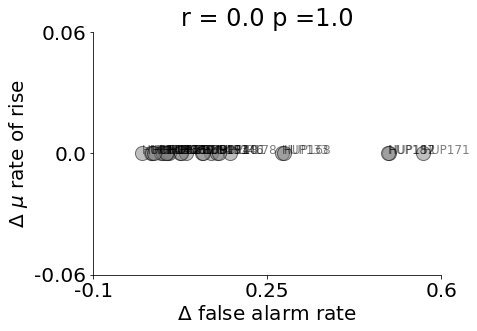

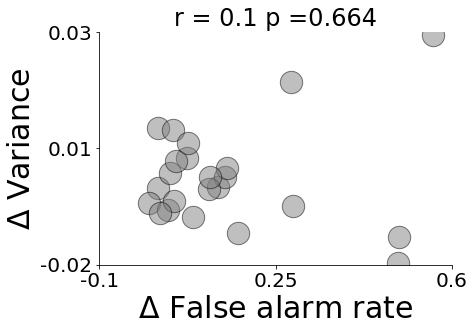

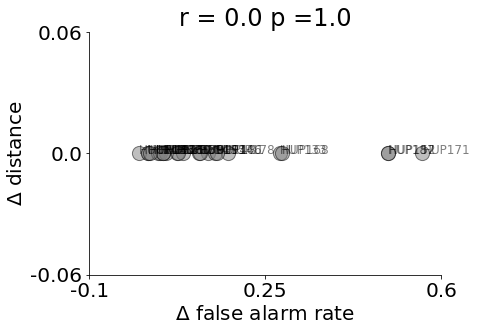

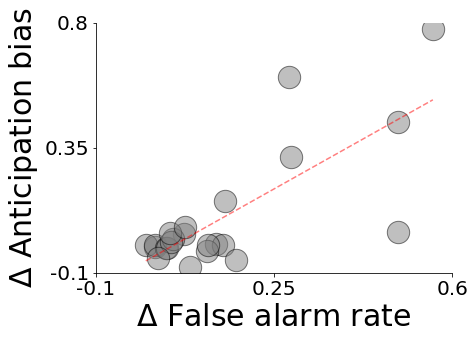

In [14]:
###  error 

# vs M (mean rate of rise)
S.plot_scatter(fp_df['error_diff'].to_numpy(),fp_df['paramsDiff_M'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ false alarm rate',fontsize=20)
ax.set_ylabel('$\Delta$ $\mu$ rate of rise',fontsize=20)
clean_fig(apply_int=False)
#plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_M_errorDiff)')


S.plot_scatter(fp_df['error_diff'].to_numpy(),fp_df['paramsDiff_S'].to_numpy(),\
               remove_zeros=remove_zeros,s=500);#,text_lbls=fp_df['subj'].to_numpy()
ax = plt.gca()
ax.set_xlabel('$\Delta$ False alarm rate',fontsize=30)
#ax.set_ylabel('$\Delta$ $\sigma$ rate of rise',fontsize=30)
ax.set_ylabel('$\Delta$ Variance',fontsize=30)
clean_fig(apply_int=False)
#plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_S_errorDiff)')


# vs M (mean rate of rise)
S.plot_scatter(fp_df['error_diff'].to_numpy(),fp_df['paramsDiff_D'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ false alarm rate',fontsize=20)
ax.set_ylabel('$\Delta$ distance',fontsize=20)
clean_fig(apply_int=False)
#plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_D_errorDiff)')


# vs M (mean rate of rise)
S.plot_scatter(fp_df['error_diff'].to_numpy(),fp_df['paramsDiff_B'].to_numpy(),\
               remove_zeros=remove_zeros,s=500, use_spearman = False);#,text_lbls=fp_df['subj'].to_numpy()
ax = plt.gca()
ax.set_xlabel('$\Delta$ False alarm rate',fontsize=30)
ax.set_ylabel('$\Delta$ Anticipation bias',fontsize=30)
clean_fig(apply_int=False)
#plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
print(plt.gca().get_title())
plt.gca().set_title('')

save_fig('fp_later_B_errorDiff)')

In [14]:
np.sort(np.round(fp_df['paramsDiff_B'].to_numpy(),2))

array([-0.08, -0.05, -0.05, -0.02, -0.01, -0.01, -0.01,  0.  , -0.  ,
       -0.  ,  0.  ,  0.  ,  0.01,  0.02,  0.04,  0.04,  0.05,  0.06,
        0.16,  0.32,  0.44,  0.6 ,  0.78])

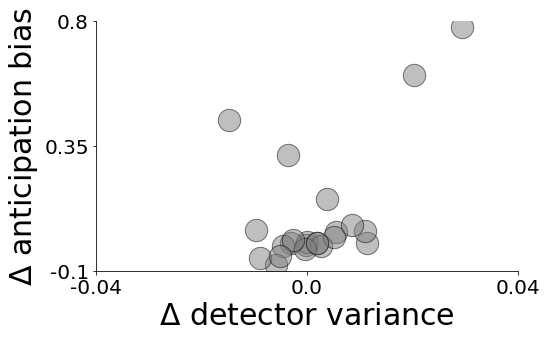

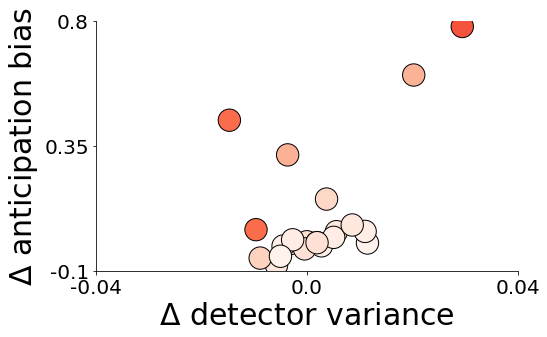

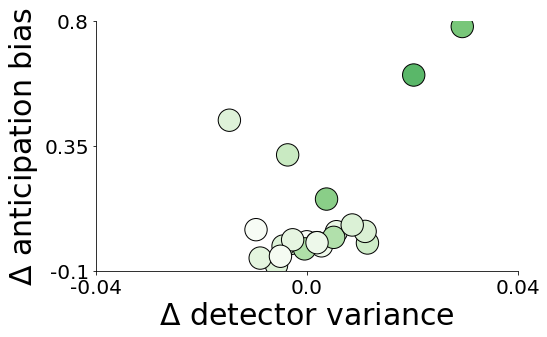

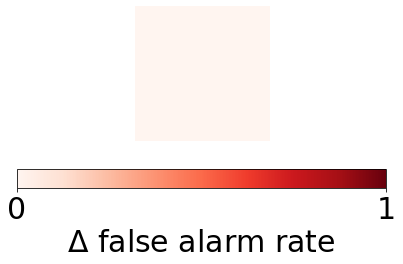

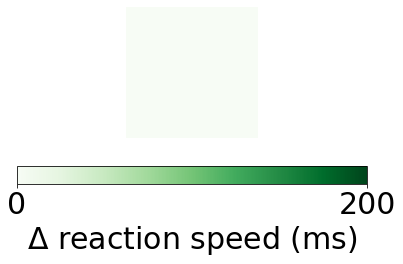

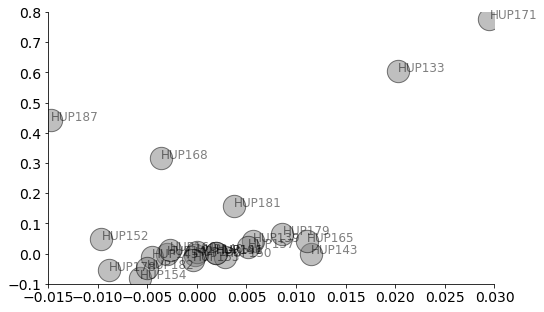

In [15]:
remove_zeros=False
param_lbl_1 = 'S' # 'D'
param_lbl_2 = 'B'


# scatter plot summarizing model (no colors)
S.plot_scatter(fp_df['paramsDiff_'+param_lbl_1].to_numpy(),fp_df['paramsDiff_'+param_lbl_2].to_numpy(),plotLine=False, \
               remove_zeros=remove_zeros,s=500,alpha=0.5,figsize=(8,5),edgecolor='k');#text_lbls=fp_df['subj'].to_numpy()
#cb = plt.colorbar(pad = 0.1,fraction = 0.05)
plt.clim(0,1)
#cb.set_label('$\Delta$ false alarm rate',fontsize=20)
#cb.ax.tick_params(labelsize=20)
plt.gca().set_xlim((-0.04,0.04))
clean_fig(apply_int=False)
plt.gca().set_xlabel('$\Delta$ detector variance',fontsize=30)
plt.gca().set_ylabel('$\Delta$ anticipation bias',fontsize=30)
save_fig('model_axes_nocolor')



# scatter plot summarizing model parameters
S.plot_scatter(fp_df['paramsDiff_'+param_lbl_1].to_numpy(),fp_df['paramsDiff_'+param_lbl_2].to_numpy(),\
               color = fp_df['error_diff'].to_numpy(),cmap = 'Reds',plotLine=False, \
               remove_zeros=remove_zeros,s=500,alpha=1,figsize=(8,5),edgecolor='k');#text_lbls=fp_df['subj'].to_numpy()
#cb = plt.colorbar(pad = 0.1,fraction = 0.05)
plt.clim(0,1)
#cb.set_label('$\Delta$ false alarm rate',fontsize=20)
#cb.ax.tick_params(labelsize=20)
plt.gca().set_xlim((-0.04,0.04))
clean_fig(apply_int=False)
plt.gca().set_xlabel('$\Delta$ detector variance',fontsize=30)
plt.gca().set_ylabel('$\Delta$ anticipation bias',fontsize=30)
save_fig('model_axes_error')


S.plot_scatter(fp_df['paramsDiff_'+param_lbl_1].to_numpy(),fp_df['paramsDiff_'+param_lbl_2].to_numpy(),\
               color = -1*fp_df['rtDiff_mean'].to_numpy(),cmap = 'Greens',plotLine=False, \
               remove_zeros=remove_zeros,s=500,alpha=1,figsize=(8,5),edgecolor='k');#text_lbls=fp_df['subj'].to_numpy()
ax = plt.gca()
#cb = plt.colorbar(pad = 0.2,fraction = 0.05)
plt.clim(0,200)
#cb.set_label('$\Delta$ reaction speed',fontsize=20)
#cb.ax.tick_params(labelsize=20)
plt.gca().set_xlim((-0.04,0.04))
clean_fig(apply_int=False)
ax.set_xlabel('$\Delta$ detector variance',fontsize=30)
ax.set_ylabel('$\Delta$ anticipation bias',fontsize=30)#ax.set_xlabel('$\Delta$ ~ detection sensitivity',fontsize=20)
#ax.set_ylabel('$\Delta$ ~ response bias',fontsize=20)
save_fig('model_axes_speed')


# plot colorbars
plt.figure()
ax= plt.subplot(111)
plt.imshow(np.zeros((10,10)),vmin=0,vmax=200,cmap = 'Reds')
plt.clim(0,1)
plt.axis('off')
cb = plt.colorbar(orientation='horizontal')

cb.set_label('$\Delta$ false alarm rate',fontsize=30)
cb.set_ticks((0,1))
cb.ax.tick_params(labelsize=30)
save_fig('model_axes_error_colorbar')


plt.figure()
ax= plt.subplot(111)
plt.imshow(np.zeros((10,10)),vmin=0,vmax=200,cmap = 'Greens')
plt.clim(0,200)
plt.axis('off')
cb = plt.colorbar(orientation='horizontal')
cb.set_label('$\Delta$ reaction speed (ms)',fontsize=30)
cb.set_ticks((0,200))
cb.ax.tick_params(labelsize=30)
save_fig('model_axes_speed_colorbar')



S.plot_scatter(fp_df['paramsDiff_'+param_lbl_1].to_numpy(),fp_df['paramsDiff_'+param_lbl_2].to_numpy(),\
               color = '0.5',cmap = 'Greens',plotLine=False, \
               remove_zeros=remove_zeros,s=500,alpha=0.5,figsize=(8,5),edgecolor='k',text_lbls=fp_df['subj'].to_numpy());#


In [24]:
# Partial Correlations: 
import pingouin as pg
#method = 'spearman'
method = 'pearson'

#Do model parameters independently explain delay-related changes in RT mean?
# rt diff vs.  variance parameter (correcting for bias parameter) 
x_lbl = 'paramsDiff_S'
y_lbl = 'rtDiff_mean'
c_lbl = 'paramsDiff_B'
corrstats = pg.partial_corr(data = fp_df, x=x_lbl,y =y_lbl,covar = c_lbl,method=method)
print(corrstats)


x_lbl = 'paramsDiff_B'
y_lbl = 'rtDiff_mean'
c_lbl = 'paramsDiff_S'
corrstats = pg.partial_corr(data = fp_df, x=x_lbl,y =y_lbl,covar = c_lbl,method=method)
print(corrstats)


#Do model parameters independently explain delay-related changes in RT std?
# rt diff vs.  variance parameter (correcting for bias parameter) 
x_lbl = 'paramsDiff_S'
y_lbl = 'rtDiff_std'
c_lbl = 'paramsDiff_B'
corrstats = pg.partial_corr(data = fp_df, x=x_lbl,y =y_lbl,covar = c_lbl,method=method)
print(corrstats)


x_lbl = 'paramsDiff_B'
y_lbl = 'rtDiff_std'
c_lbl = 'paramsDiff_S'
corrstats = pg.partial_corr(data = fp_df, x=x_lbl,y =y_lbl,covar = c_lbl,method=method)
print(corrstats)


#Do model parameters independently explain delay-related faster RTs?
# rt diff vs.  variance parameter (correcting for bias parameter) 
x_lbl = 'paramsDiff_S'
y_lbl = 'error_diff'
c_lbl = 'paramsDiff_B'
corrstats = pg.partial_corr(data = fp_df, x=x_lbl,y =y_lbl,covar = c_lbl,method=method)
print(corrstats)


x_lbl = 'paramsDiff_B'
y_lbl = 'error_diff'
c_lbl = 'paramsDiff_S'
corrstats = pg.partial_corr(data = fp_df, x=x_lbl,y =y_lbl,covar = c_lbl,method=method)
print(corrstats)

          n         r         CI95%     p-val
pearson  23 -0.399855  [-0.7, 0.03]  0.065213
          n         r           CI95%     p-val
pearson  23 -0.459466  [-0.74, -0.05]  0.031457
          n         r         CI95%     p-val
pearson  23  0.718094  [0.43, 0.87]  0.000168
          n         r           CI95%     p-val
pearson  23 -0.534905  [-0.78, -0.15]  0.010317
          n         r         CI95%     p-val
pearson  23 -0.572628  [-0.8, -0.2]  0.005349
          n         r         CI95%         p-val
pearson  23  0.843158  [0.65, 0.93]  8.368247e-07


                            OLS Regression Results                            
Dep. Variable:            rtDiff_mean   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     9.931
Date:                Fri, 21 Jan 2022   Prob (F-statistic):            0.00101
Time:                        09:51:22   Log-Likelihood:                -104.19
No. Observations:                  23   AIC:                             214.4
Df Residuals:                      20   BIC:                             217.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -28.9691      5.533     -5.236   

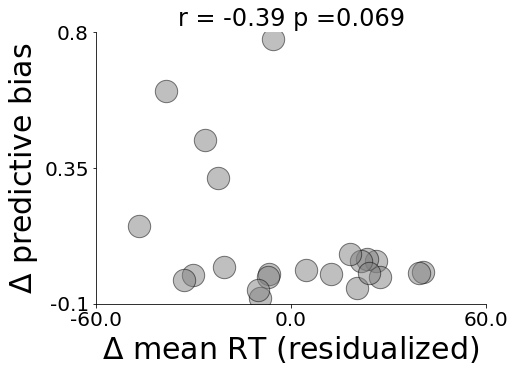

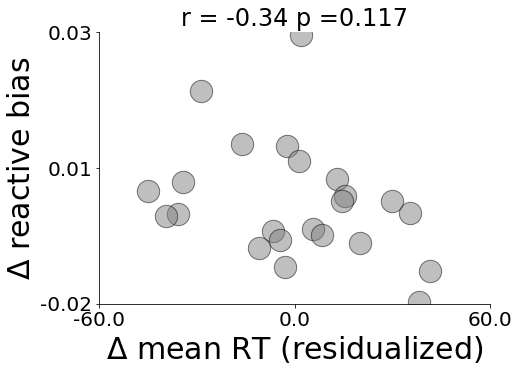

In [33]:
# multi-variate linear regression: RT Mean vs. model parameters (plot residuals)
import statsmodels.formula.api as smf

# compute model (rt diff mean)
reg_rtMean_mult = smf.ols('rtDiff_mean ~ paramsDiff_B + paramsDiff_S',\
                             data = fp_df).fit()
print(reg_rtMean_mult.summary())



reg_rtMean_S = smf.ols('rtDiff_mean ~ paramsDiff_S',\
                             data = fp_df).fit()
S.plot_scatter(reg_rtMean_S.resid,fp_df['paramsDiff_B'],s=500)
ax = plt.gca()
ax.set_xlabel('$\Delta$ mean RT (residualized)',fontsize=30)
ax.set_ylabel('$\Delta$ predictive bias',fontsize=30)
clean_fig(apply_int=False)


reg_rtMean_B = smf.ols('rtDiff_mean ~ paramsDiff_B',\
                             data = fp_df).fit()
S.plot_scatter(reg_rtMean_B.resid,fp_df['paramsDiff_S'],s=500)
ax = plt.gca()
ax.set_xlabel('$\Delta$ mean RT (residualized)',fontsize=30)
ax.set_ylabel('$\Delta$ reactive bias',fontsize=30)
clean_fig(apply_int=False)
#plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
#save_fig('fp_later_M_errorDiff)')



                            OLS Regression Results                            
Dep. Variable:             rtDiff_std   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     10.73
Date:                Fri, 21 Jan 2022   Prob (F-statistic):           0.000684
Time:                        09:56:47   Log-Likelihood:                -96.347
No. Observations:                  23   AIC:                             198.7
Df Residuals:                      20   BIC:                             202.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -10.1294      3.935     -2.574   

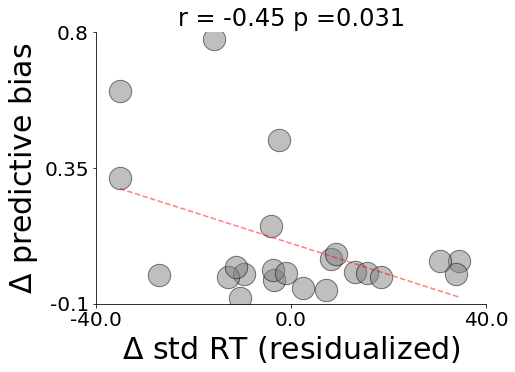

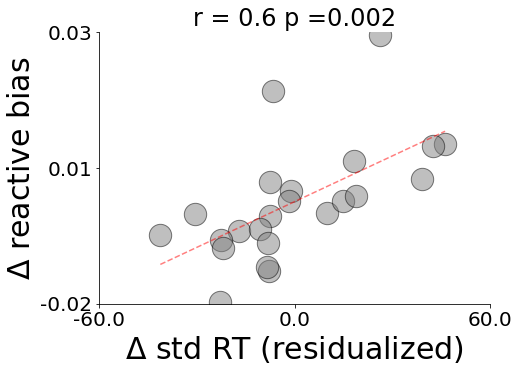

In [38]:
# multi-variate linear regression: RT STD vs. model parameters (plot residuals)
# compute model (rt diff mean)
reg_rtStd_mult = smf.ols('rtDiff_std ~ paramsDiff_B + paramsDiff_S',\
                             data = fp_df).fit()
print(reg_rtStd_mult.summary())

reg_rtStd_S = smf.ols('rtDiff_std ~ paramsDiff_S',\
                             data = fp_df).fit()
S.plot_scatter(reg_rtStd_S.resid,fp_df['paramsDiff_B'],s=500)
ax = plt.gca()
ax.set_xlabel('$\Delta$ std RT (residualized)',fontsize=30)
ax.set_ylabel('$\Delta$ predictive bias',fontsize=30)
clean_fig(apply_int=False)


reg_rtStd_B = smf.ols('rtDiff_std ~ paramsDiff_B',\
                             data = fp_df).fit()
S.plot_scatter(reg_rtStd_B.resid,fp_df['paramsDiff_S'],s=500)
ax = plt.gca()
ax.set_xlabel('$\Delta$ std RT (residualized)',fontsize=30)
ax.set_ylabel('$\Delta$ reactive bias',fontsize=30)
clean_fig(apply_int=False)
#plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
#save_fig('fp_later_M_errorDiff)')

                            OLS Regression Results                            
Dep. Variable:             rtDiff_std   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     10.73
Date:                Fri, 21 Jan 2022   Prob (F-statistic):           0.000684
Time:                        09:55:44   Log-Likelihood:                -96.347
No. Observations:                  23   AIC:                             198.7
Df Residuals:                      20   BIC:                             202.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -10.1294      3.935     -2.574   

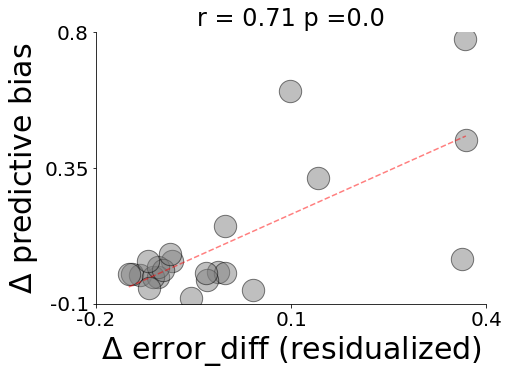

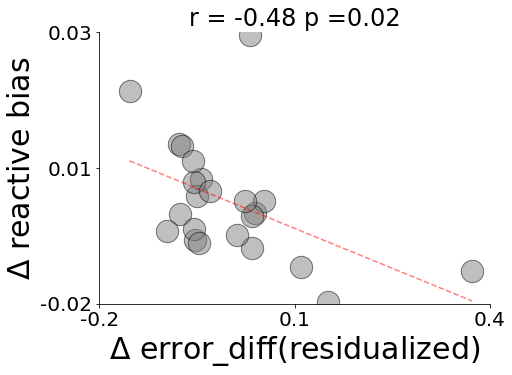

In [37]:
# multi-variate linear regression: Error diff vs. model parameters (plot residuals)
# compute model (rt diff mean)
reg_errorDiff_mult = smf.ols('error_diff ~ paramsDiff_B + paramsDiff_S',\
                             data = fp_df).fit()
print(reg_rtStd_mult.summary())

reg_errorDiff_S = smf.ols('error_diff ~ paramsDiff_S',\
                             data = fp_df).fit()
S.plot_scatter(reg_errorDiff_S.resid,fp_df['paramsDiff_B'],s=500)
ax = plt.gca()
ax.set_xlabel('$\Delta$ error_diff (residualized)',fontsize=30)
ax.set_ylabel('$\Delta$ predictive bias',fontsize=30)
clean_fig(apply_int=False)


reg_errorDiff_B = smf.ols('error_diff ~ paramsDiff_B',\
                             data = fp_df).fit()
S.plot_scatter(reg_errorDiff_B.resid,fp_df['paramsDiff_S'],s=500)
ax = plt.gca()
ax.set_xlabel('$\Delta$ error_diff(residualized)',fontsize=30)
ax.set_ylabel('$\Delta$ reactive bias',fontsize=30)
clean_fig(apply_int=False)

In [34]:
#SUBGROUP ANALYSIS on subjects that showed low error rates (< 0.25)
subj_query  = 'error_diff<0.25'
#LATER model parameters vs. RT changes
remove_zeros=False

###  RT mean 

# vs M (mean rate of rise)
S.plot_scatter(fp_df.query(subj_query)['rtDiff_mean'].to_numpy(),fp_df.query(subj_query)['paramsDiff_M'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ mean RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ $\mu$ rate of rise',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_M_rtMean-lowErrorSubjects)')

# vs S (std rate of rise)
S.plot_scatter(fp_df.query(subj_query)['rtDiff_mean'].to_numpy(),fp_df.query(subj_query)['paramsDiff_S'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ mean RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ $\sigma$ rate of rise',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_S_rtMean-lowErrorSubjects)')


# vs D (distance)
S.plot_scatter(fp_df.query(subj_query)['rtDiff_mean'].to_numpy(),fp_df.query(subj_query)['paramsDiff_D'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ mean RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ distance',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_D_rtMean-lowErrorSubjects)')


S.plot_scatter(fp_df.query(subj_query)['rtDiff_mean'].to_numpy(),fp_df.query(subj_query)['paramsDiff_B'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ mean RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ bias',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_D_rtMean-lowErrorSubjects)')
###  RT std 

# vs M (mean rate of rise)
S.plot_scatter(fp_df.query(subj_query)['rtDiff_std'].to_numpy(),fp_df.query(subj_query)['paramsDiff_M'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ std RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ $\mu$ rate of rise',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_M_rtStd-lowErrorSubjects)')


# vs S (std rate of rise)
S.plot_scatter(fp_df.query(subj_query)['rtDiff_std'].to_numpy(),fp_df.query(subj_query)['paramsDiff_S'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ std RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ $\sigma$ rate of rise',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_S_rtStd-lowErrorSubjects)')

# vs D (distance)
S.plot_scatter(fp_df.query(subj_query)['rtDiff_std'].to_numpy(),fp_df.query(subj_query)['paramsDiff_D'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ std RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ distance',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_D_rtStd-lowErrorSubjects)')

S.plot_scatter(fp_df.query(subj_query)['rtDiff_std'].to_numpy(),fp_df.query(subj_query)['paramsDiff_B'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ std RT (ms)',fontsize=20)
ax.set_ylabel('$\Delta$ bias',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_D_rtStd-lowErrorSubjects)')




###  error diff

# vs M (mean rate of rise)
S.plot_scatter(fp_df.query(subj_query)['error_diff'].to_numpy(),fp_df.query(subj_query)['paramsDiff_M'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ anticipatory \n false alarm rate',fontsize=20)
ax.set_ylabel('$\Delta$ $\mu$ rate of rise',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_M_errorDiff-lowErrorSubjects)')


# vs S (std rate of rise)
S.plot_scatter(fp_df.query(subj_query)['error_diff'].to_numpy(),fp_df.query(subj_query)['paramsDiff_S'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ anticipatory \n false alarm rate',fontsize=20)
ax.set_ylabel('$\Delta$ $\sigma$ rate of rise',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_S_errorDiff-lowErrorSubjects)')

# vs D (distance)
S.plot_scatter(fp_df.query(subj_query)['error_diff'].to_numpy(),fp_df.query(subj_query)['paramsDiff_D'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ anticipatory \n false alarm rate',fontsize=20)
ax.set_ylabel('$\Delta$ distance',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_D_errorDiff-lowErrorSubjects)')

S.plot_scatter(fp_df.query(subj_query)['error_diff'].to_numpy(),fp_df.query(subj_query)['paramsDiff_B'].to_numpy(),\
               remove_zeros=remove_zeros,s=200,text_lbls=fp_df.query(subj_query)['subj'].to_numpy());
ax = plt.gca()
ax.set_xlabel('$\Delta$ anticipatory \n false alarm rate',fontsize=20)
ax.set_ylabel('$\Delta$ bias',fontsize=20)
clean_fig(apply_int=False)
plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
save_fig('fp_later_D_errorDiff-lowErrorSubjects)')

PatsyError: Error evaluating factor: NameError: name 'rtStd_mean' is not defined
    rtStd_mean ~ paramsDiff_B + paramsDiff_S
    ^^^^^^^^^^

In [1]:
remove_zeros=False
param_lbl_1 = 'S' # 'D'
param_lbl_2 = 'B'

# scatter plot summarizing model parameters
S.plot_scatter(fp_df.query(subj_query)['paramsDiff_'+param_lbl_1].to_numpy(),fp_df.query(subj_query)['paramsDiff_'+param_lbl_2].to_numpy(),\
               color = fp_df.query(subj_query)['error_diff'].to_numpy(),cmap = 'Reds',plotLine=False, \
               remove_zeros=remove_zeros,s=500,text_lbls=fp_df.query(subj_query)['subj'].to_numpy(),alpha=0.75,figsize=(7,5));
ax = plt.gca()
plt.colorbar(pad = 0.1,fraction = 0.05,label = '$\Delta$ error rate')
ax.set_xlabel('$\Delta$ reaction $\sigma$',fontsize=20)
ax.set_ylabel('$\Delta$ anticipation bias',fontsize=20)
save_fig('model_axes_error_lowErrorSubjects')


S.plot_scatter(fp_df.query(subj_query)['paramsDiff_'+param_lbl_1].to_numpy(),fp_df.query(subj_query)['paramsDiff_'+param_lbl_2].to_numpy(),\
               color = -1*fp_df.query(subj_query)['rtDiff_mean'].to_numpy(),cmap = 'Greens',plotLine=False, \
               remove_zeros=remove_zeros,s=500,text_lbls=fp_df.query(subj_query)['subj'].to_numpy(),alpha=0.75,figsize=(7,5));
ax = plt.gca()
plt.colorbar(pad = 0.1,fraction = 0.05,label = '$\Delta$ reaction speed')
ax.set_xlabel('$\Delta$ reaction $\sigma$',fontsize=20)
ax.set_ylabel('$\Delta$ anticipation bias',fontsize=20)

#ax.set_xlabel('$\Delta$ ~ detection sensitivity',fontsize=20)
#ax.set_ylabel('$\Delta$ ~ response bias',fontsize=20)
save_fig('model_axes_speed_lowErrorSubjects')

NameError: name 'S' is not defined